In [1]:
pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast

import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)
from utils import prepare_data, TimeMoEPredictor, chronosPredictor, LLM, wape

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from statsforecast.utils import ConformalIntervals

intervals = ConformalIntervals(h=3, n_windows=3)



/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data

In [101]:
train, test = prepare_data(sample_size=1000,series_cutoff=72,min_series_length=60)

/Users/xcx7787/m4_tests/utils.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))
/Users/xcx7787/m4_tests/utils.py:66: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["max"] = df.groupby("unique_id")["ds"].transform(max)


In [105]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(prediction_intervals=intervals),
    AutoETS(prediction_intervals=intervals),
    Naive(prediction_intervals=intervals)
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality'],
               #prediction_intervals=intervals
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

#model_classes_custom = [TimeMoEPredictor(input_length=24,device="cpu"),chronosPredictor(input_length=24,device="cpu")]


Seed set to 1


In [109]:
model_wrappers = {}
model_names = []

neural = False
stats = True
ML = True
custom = False

if ML:
    for model in model_classes_ml:
        model_name = str(model).split("(")[0]
        model_names.append(model_name)
        model_wrappers[model_name]=(
            MLForecast(
                models=model,
                freq='ME',
                #lags=[1,2,3],
                #lag_transforms={
                #    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                #},
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_name = str(type(model).__name__)
        model_names.append(model_name)
        model_wrappers[model_name] = model

if neural:
    for model in model_classes_neural:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            NeuralForecast( 
                models=[model],
                freq='ME'
            )
        )    

if stats:
    for model in models_classes_stats:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    


In [111]:
fit_times = []

for model_name, model in model_wrappers.items():
    if isinstance(model, MLForecast):
        start = time.time()
        model.fit(df=train, prediction_intervals=intervals )
        fit_times.append(time.time()-start)

    elif isinstance(model, StatsForecast):
        start = time.time()
        model.fit(df=train )
        fit_times.append(time.time()-start)
    

KeyboardInterrupt: 

In [31]:
forecast_dict = {}
forecast_times = []

levels = [95]

def add_model(forecasts,model_name):
    forecast_dict[model_name] = forecasts
    
for model_name, model in model_wrappers.items():
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        add_model(model.predict().reset_index(),model_name)
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        add_model(model.predict(h=3,level=levels),model_name)
    else:
        add_model(model.predict(train,test,h=3),model_name)
        fit_times.append(0)

    forecast_times.append(time.time()-start)


StatsForecast(models=[DynamicOptimizedTheta])
StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])
StatsForecast(models=[Naive])


In [36]:
forecast_dict["DynamicOptimizedTheta"]

,unique_id,ds,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-95,DynamicOptimizedTheta-hi-95
0,M10000,2017-01-31,2463.288818,2168.397705,2814.498779
1,M10000,2017-02-28,2463.288818,1961.736328,2933.127441
2,M10000,2017-03-31,2463.288818,1805.173340,3046.237305
3,M10127,2016-07-31,1103.183350,1042.228638,1175.779297
4,M10127,2016-08-31,1104.636230,1033.873291,1171.625732
...,...,...,...,...,...
2902,M9942,2017-02-28,1720.799927,1270.755005,2142.388184
2903,M9942,2017-03-31,1720.799927,1130.270386,2243.881836
2904,M9964,2017-01-31,520.901978,370.265228,700.307495
2905,M9964,2017-02-28,520.901978,264.698334,760.905640


In [32]:
forecast_times

[5.218023061752319, 1.856058120727539, 1.779714822769165, 1.7099997997283936]

In [33]:
train

,unique_id,y,ds
0,M10000,2740.0,2013-05-31
1,M10000,3000.0,2013-06-30
2,M10000,3040.0,2013-07-31
3,M10000,2920.0,2013-08-31
4,M10000,2870.0,2013-09-30
...,...,...,...
46504,M9964,700.0,2016-08-31
46505,M9964,630.0,2016-09-30
46506,M9964,630.0,2016-10-31
46507,M9964,610.0,2016-11-30


In [34]:
weights = (
    train
        .groupby("unique_id",)["y"]
        .sum()
        .rename("weights")
)

weights = weights/weights.sum()

In [13]:
metrics = [
    mape,
    wape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [14]:
test = test.reset_index()

for name,forecast in forecast_dict.items():
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [15]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [16]:
eval[eval["metric"]=='wape']

,unique_id,metric,index,DynamicOptimizedTheta,AutoARIMA,AutoETS,Naive
969,M10000,wape,55.811594,0.075334,0.132681,0.075875,0.075881
970,M10127,wape,10.829787,0.006670,0.005790,0.004706,0.010909
971,M1013,wape,15.760563,0.421654,0.430123,0.312701,0.184932
972,M10176,wape,16.712456,0.008163,0.068563,0.066508,0.066508
973,M10280,wape,30.602241,0.002676,0.028208,0.006735,0.002577
...,...,...,...,...,...,...,...
1933,M9825,wape,0.938829,0.254173,0.214118,0.274197,0.133333
1934,M983,wape,0.872608,0.029149,0.013052,0.036268,0.036257
1935,M9922,wape,0.982333,0.180159,0.114213,0.180002,0.180000
1936,M9942,wape,0.967716,0.128312,0.127907,0.127911,0.127907


In [17]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).corr()

0                                        
metric        mape      mase      rmse     rmsse      wape
  metric                                                  
0 mape    1.000000  0.178456  0.453116  0.164858  0.349711
  mase    0.178456  1.000000  0.356258  0.969051  0.333046
  rmse    0.453116  0.356258  1.000000  0.384836  0.693280
  rmsse   0.164858  0.969051  0.384836  1.000000  0.337849
  wape    0.349711  0.333046  0.693280  0.337849  1.000000

In [18]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).describe()

0                                                     
metric         mape         mase          rmse        rmsse         wape
count   3876.000000  3876.000000   3876.000000  3876.000000  3876.000000
mean       0.140642     0.813282    508.415055     0.730504     0.110482
std        0.487601     1.152593   1276.413375     0.996572     0.259212
min        0.000000     0.000000      0.000000     0.000000     0.000000
25%        0.013340     0.232423     53.213945     0.221410     0.013407
50%        0.038493     0.499004    158.642179     0.462817     0.038527
75%        0.118136     0.958944    425.662791     0.888273     0.118280
max        9.022224    17.106852  19468.361355    13.808181     6.932441

In [19]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

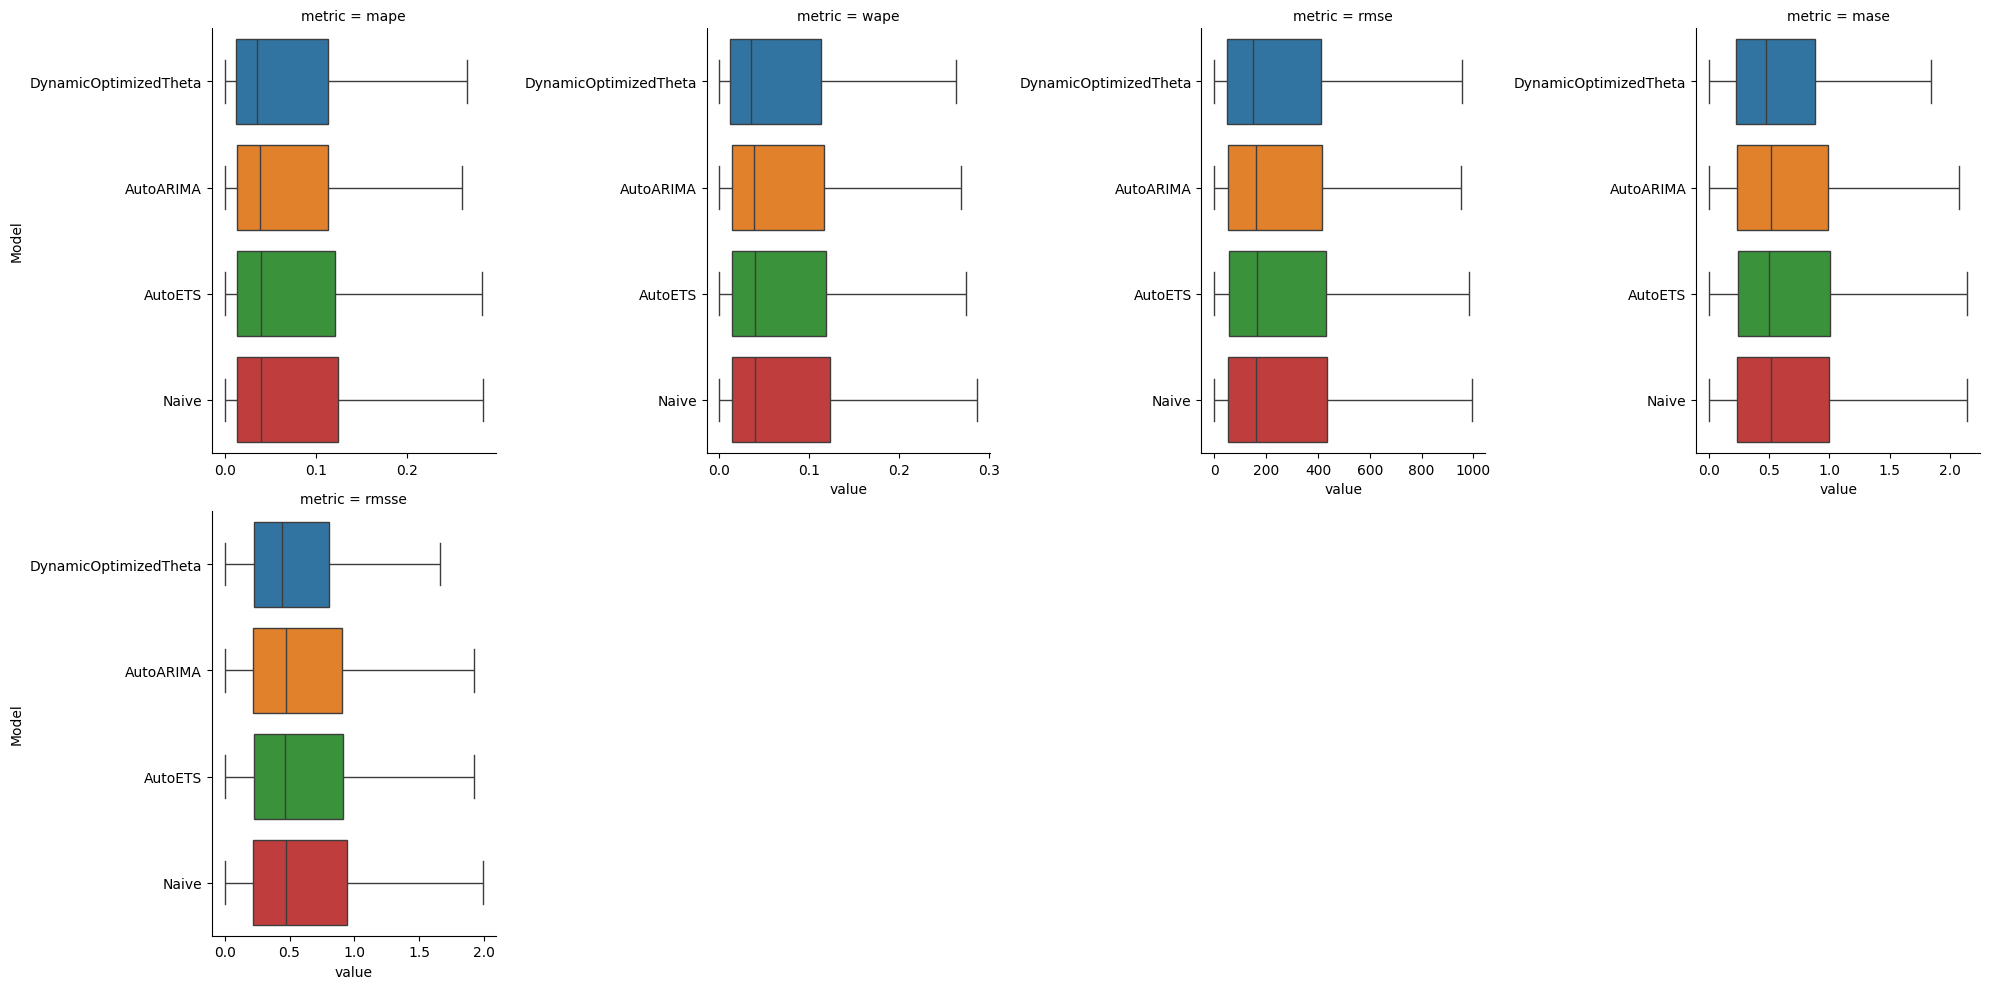

In [20]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [21]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_time":fit_times,
        "inference_time":forecast_times
    }
).set_index("Model")

In [22]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,Naive
metric,,,,
mape,0.038461,0.039633,0.035721,0.039860
mase,0.511419,0.500635,0.470549,0.511628
rmse,159.852373,163.299327,149.430541,159.613074
rmsse,0.471542,0.463152,0.439620,0.476075
wape,0.038321,0.039940,0.035502,0.040000


In [23]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

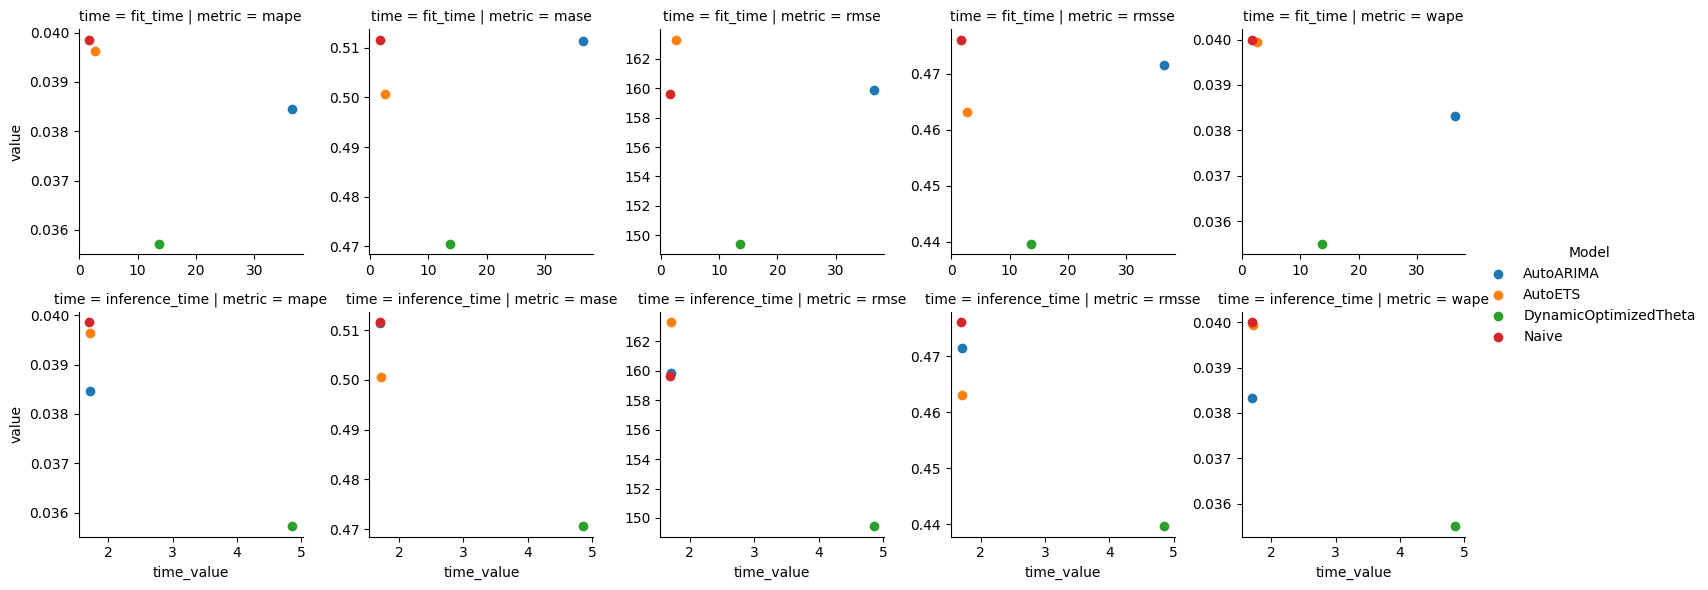

In [24]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()

In [25]:
(
    metrics
        #[metrics.index.get_level_values(level=1).isin(["rmsse","rmse","mape","wape"])]
        .reset_index().merge(weights, on = "unique_id")
        .assign(metric = lambda x : "w"+x["metric"],
                value = lambda x : x.value*x.weights
                )
        .groupby(["metric","Model"])["value"]
        .sum()
        .sort_values()
        .unstack(level=0)
        .reset_index()
        .sort_values(by="wrmsse")
)

metric,Model,wmape,wmase,wrmse,wrmsse,wwape
2,DynamicOptimizedTheta,0.125231,0.663074,634.690129,0.607020,0.092416
0,AutoARIMA,0.117920,0.792091,643.772279,0.716484,0.095854
1,AutoETS,0.130533,0.833343,671.326671,0.747640,0.098599
3,Naive,0.137313,0.864538,727.560230,0.776801,0.109469


In [26]:
df = metrics.unstack(level=1).reset_index().drop(columns=["unique_id"])

In [27]:
from itertools import product
from scipy import stats
import pandas as pd

cols = df.columns.difference(['Model'])

g = df.groupby('Model')[cols]

out = pd.concat({(a, b): pd.DataFrame(stats.ttest_rel(g.get_group(a), g.get_group(b),alternative="less"),
                                      columns=cols, index=['statistic', 'pvalue'])
                 for a, b in product(df['Model'].unique(), repeat=2)
                }, names=['product1', 'product2'])


<Axes: xlabel='None-product2', ylabel='product1-metric'>

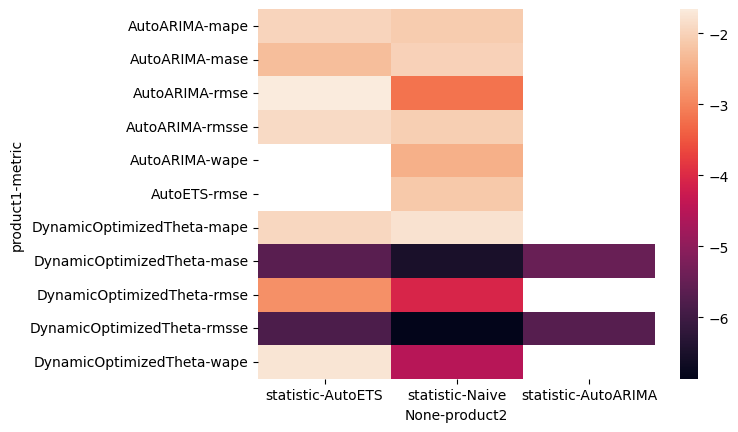

In [28]:
sns.heatmap(out.stack().unstack(level=2).loc[lambda x : x.pvalue <0.05].drop(columns="pvalue").unstack(level=1))